<a href="./eumetsat_00_fire_monitoring.ipynb"><< Introduction </a><br>


# Fire Monitoring in Siberia

The following workflow is based on Sentinel-3 NRT SLSTR FRP data sensed on 27 June 2020 in Siberia.

## Loading packages

In [1]:
import xarray as xr   # netCDF format is better handled with the xarray
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as pltfacebook
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Loading functions
EUMETSAT team has provided a set of <a href="./functions.ipynb">functions</a> for data gridding, processing, and visualisation. Such functions are the core of this workflow.

In [2]:
# ipynb is a package import Jupyter Notebooks files (.ipynb) the same way you would import regular .py files.

from ipynb.fs.full.functions import generate_masked_array, visualize_s3_frp, slstr_frp_gridding

## Loading data

We read the file using xarray and display the file content. 
First, we identify the `Dimensions` of the dataset.
There is no information in the `Coordinates` section because the file is not gridded
Under `Data variables` we identify what is available in the file and the data type of each variable.
Last, the header is displayed in `Attributes` describing when, how, where the data comes from. 

Note that fire detection using Sentinel-3 NRT SLSTR data depends on the measurements used to compute FRP (thermal and/or MWIR radiometric measurements). Thus, a fire can be associated with FRP_MIR and/or FRP_SWIR. For in-depth information visit the [*ESA technical guide*](https://earth.esa.int/web/sentinel/technical-guides/sentinel-3-slstr/level-2/fire-radiative-power-frp).


In [3]:
file_dir = './eodata/'
frp_xr = xr.open_dataset(file_dir+'FRP_in_Siberia_202000627.nc')
frp_xr


<xarray.Dataset>
Dimensions:                 (columns: 1500, fires: 1108, rows: 2000)
Dimensions without coordinates: columns, fires, rows
Data variables:
    i                       (fires) int16 ...
    j                       (fires) int32 ...
    time                    (fires) datetime64[ns] ...
    latitude                (fires) float64 ...
    longitude               (fires) float64 ...
    FRP_MWIR                (fires) float64 ...
    FRP_uncertainty_MWIR    (fires) float64 ...
    transmittance_MWIR      (fires) float64 ...
    FRP_SWIR                (fires) float64 ...
    FRP_uncertainty_SWIR    (fires) float64 ...
    FLAG_SWIR_SAA           (fires) int16 ...
    transmittance_SWIR      (fires) float64 ...
    confidence              (fires) float64 ...
    classification          (fires) uint8 ...
    S7_Fire_pixel_radiance  (fires) float32 ...
    F1_Fire_pixel_radiance  (fires) float32 ...
    used_channel            (fires) uint8 ...
    Radiance_window         (fires) float32 ...
    Glint_angle             (fires) float64 ...
    IFOV_area               (fires) float64 ...
    TCWV                    (fires) float64 ...
    n_window                (fires) int16 ...
    n_water                 (fires) int16 ...
    n_cloud                 (fires) int16 ...
    n_SWIR_fire             (fires) float32 ...
    flags                   (rows, columns) uint32 ...
Attributes:
    title:                  SLSTR Level 2 Product, Fire Radiative Power measu...
    comment:                 
    netCDF_version:         4.2 of Jul  5 2012 17:07:43 $
    product_name:           S3A_SL_2_FRP____20200627T111323_20200627T111823_2...
    institution:            MAR
    source:                 IPF-SL-2-FRP 02.00
    history:                 
    references:             S3MPC ACR FRP 003 - i1r2 - SLSTR L2 Product Data ...
    contact:                ops@eumetsat.int
    creation_time:          2020-06-27T13:46:19Z
    resolution:             [ 1000 1000 ]
    absolute_orbit_number:  22711
    start_time:             2020-06-27T11:13:22.962714Z
    stop_time:              2020-06-27T11:18:22.948658Z
    track_offset:           998
    start_offset:           5632

## Data exploration

Let's take a quick look into the variables `FRP_MWIR` and `FRP_SWIR`, which contain the information about the detected fires. In the previous [summary](./00_eumetsat_fire_monitoring.ipynb#Summary), the acronyms MWIR and SWIR are described under *channels*. 

`FRP_MWIR` shows 1108 fires detected and contains positive numerical values, which we can verify by plotting these values. 

<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.712728,  3.450277, 27.888621, ...,  3.480033,  3.40337 ,  2.624291])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW


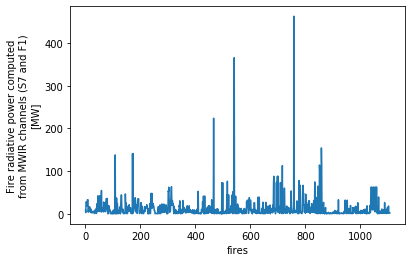

In [4]:
print(frp_xr['FRP_MWIR'])
frp_xr['FRP_MWIR'].plot()

Note that the data array `FRP_SWIR` displays negative unitary values (i.e., -1.). If we look into the The variable `FLAG_SWIR_SAA`, it indicates the meaning of such flag values as follows:
- -1 = NA 
-  0 = Unlikely 
- +1 = Possible  
which means this data array contains missing values. When we plot this data variable we see there are only missing values. Our fist conclusion exploring this data is that  the data variable `FRP_SWIR` does not provide information for fire detection in Siberia on that date. The analysis then focuses on `FRP_MWIR` data.

<xarray.DataArray 'FLAG_SWIR_SAA' (fires: 1108)>
array([-1, -1, -1, ..., -1, -1, -1], dtype=int16)
Dimensions without coordinates: fires
Attributes:
    long_name:      Flag South Atlantic Anomaly (SAA) suspected from SWIR cha...
    flag_values:    [-1  0  1  2  3  4]
    flag_meanings:  NA Unlikely Possible Spare Spare Spare 


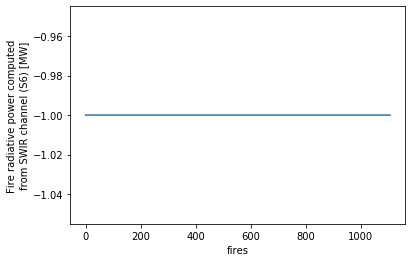

In [5]:
print(frp_xr['FLAG_SWIR_SAA'])
frp_xr['FRP_SWIR'].plot()


## Georeference

Now, let's get the coordinates information (latitude and longitud) required to make a regular grid for plotting.

In [6]:
lat_frp = frp_xr['latitude']
lon_frp = frp_xr['longitude']

print(f"{lat_frp}\n\n{lon_frp}")

<xarray.DataArray 'latitude' (fires: 1108)>
array([53.275708, 53.269671, 55.355927, ..., 67.347698, 67.341288, 67.359559])
Dimensions without coordinates: fires
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degrees_north
    valid_min:      -90.0
    valid_max:      90.0

<xarray.DataArray 'longitude' (fires: 1108)>
array([157.932706, 157.921463, 159.257392, ..., 153.806634, 153.744799,
       153.834013])
Dimensions without coordinates: fires
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degrees_east
    valid_min:      -180.0
    valid_max:      180.0


We select the bounds of the georeferenced frame based on the minima and maxima data values of latitude and longitud. 

In [7]:
lat_min = lat_frp.values.min()
lat_max = lat_frp.values.max()
lon_min = lon_frp.values.min()
lon_max = lon_frp.values.max()

sampling_lat_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
sampling_lon_FRP_grid = 0.25        # Sampling for gridded FRP values & differenrce  stats computation 
FRP_plot_max_grid     = 50.         # Max Integrated FRP value, for plots


## Selecting valid pixels

At this point, we know that missing values are -1, therefore valid pixels are different to -1. We also know that all pixels in `FRP_MWIR` are positive, so there are no missing values, and data can be gridded directly.

However, for the purpose of stablishing a data processing workflow we will mask the data assuming there could be missing values in the data. Thus, applying the function [generate_masked_array](./functions.ipynb#generate_masked_array) extracts the right pixels to be plotted. We must chose the sampling rate for building the regular grid. 

In [8]:
masked_frp_mwir = generate_masked_array(frp_xr['FRP_MWIR'], frp_xr['FRP_MWIR'], -1.,operator='!=', drop=True)
masked_frp_mwir


<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.71272752,  3.45027709, 27.88862075, ...,  3.4800329 ,
        3.40336956,  2.62429088])
Dimensions without coordinates: fires


<xarray.DataArray 'FRP_MWIR' (fires: 1108)>
array([ 8.71272752,  3.45027709, 27.88862075, ...,  3.4800329 ,
        3.40336956,  2.62429088])
Dimensions without coordinates: fires
Attributes:
    long_name:  Fire radiative power computed from MWIR channels (S7 and F1)
    units:      MW

After having selected the valid pixels to plot, we can compare the number of total fires and the number of fires in the original data file with the number of fires detected after selecting only the valid pixels. In this case, both are exactly the same: 1108 fires.

In [9]:
n_fire_tot           = len(lat_frp[:])
n_fire_MWIR          = len(masked_frp_mwir.to_masked_array().compressed())

n_fire_tot, n_fire_MWIR

(1108, 1108)

## Gridding FRP data

To compute the gridded FRP data onto a latitude and logitud frame, it is neccesary to sum FRP values within a grid cell using the function [slstr_frp_gridding](./functions.ipynb#slstr_frp_gridding).

In [10]:
FRP_MWIR_grid, lat_grid, lon_grid = slstr_frp_gridding(frp_xr['FRP_MWIR'],
                                                       lat_frp,
                                                       lon_frp,
                                                       'mwir', 
                                                       lat_min, lat_max, lon_min, lon_max, 
                                                       sampling_lat_FRP_grid,
                                                       sampling_lon_FRP_grid, 
                                                       n_fire_MWIR)


In [11]:
FRP_MWIR_grid, lat_grid, lon_grid

(array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        ...,
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
        [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
       dtype=float32),
 array([[53.394672, 53.394672, 53.394672, ..., 53.394672, 53.394672,
         53.394672],
        [53.644672, 53.644672, 53.644672, ..., 53.644672, 53.644672,
         53.644672],
        [53.894672, 53.894672, 53.894672, ..., 53.894672, 53.894672,
         53.894672],
        ...,
        [67.14467 , 67.14467 , 67.14467 , ..., 67.14467 , 67.14467 ,
         67.14467 ],
        [67.39467 , 67.39467 , 67.39467 , ..., 67.39467 , 67.39467 ,
         67.39467 ],
        [67.64467 , 67.64467 , 67.64467 , ..., 67.64467 , 67.64467 ,
         67.64467 ]], dtype=float32),
 array([[131.88

Observe that the gridded array contains negative values (-9999), which are indeed invalid pixels and must be masked out before plotting. We do this as follow:


In [12]:
mask_out = np.where(FRP_MWIR_grid[:,:] != -9999., False, True)

FRP_MWIR_clean = np.ma.masked_array(FRP_MWIR_grid[:,:], mask=mask_out)
FRP_MWIR_clean

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20,
  dtype=float32)

## FRP data visualisation

Applying the `visualize_s3_frp` function we can finally plot the fires (hotspots) detected with the product NRT FRP in Siberia. 


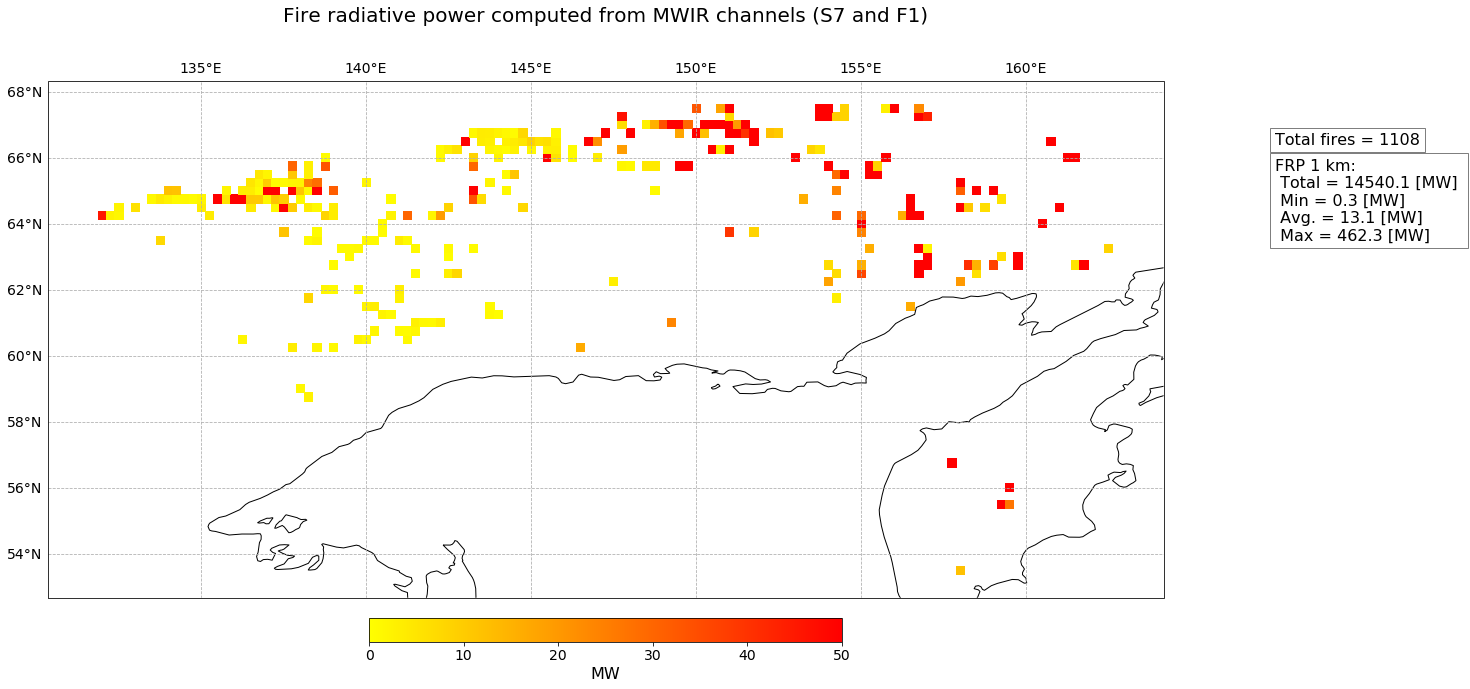

In [13]:
textstr_1 = 'Total fires = ' + str(n_fire_MWIR)

FRP_sum      = np.sum(masked_frp_mwir.to_masked_array().compressed())
FRP_mean     = np.mean(masked_frp_mwir.to_masked_array().compressed())
FRP_std      = np.std(masked_frp_mwir.to_masked_array().compressed())
FRP_min      = np.min(masked_frp_mwir.to_masked_array().compressed())
FRP_max      = np.max(masked_frp_mwir.to_masked_array().compressed())

FRP_sum_str  = '%.1f' % FRP_sum
FRP_mean_str = '%.1f' % FRP_mean
FRP_std_str  = '%.1f' % FRP_std
FRP_min_str  = '%.1f' % FRP_min
FRP_max_str  = '%.1f' % FRP_max

textstr_2 = 'FRP 1 km: \n Total = '+FRP_sum_str+' [MW] \n Min = ' + FRP_min_str + ' [MW] \n Avg. = '+ FRP_mean_str + ' [MW] \n Max = ' + FRP_max_str + ' [MW]'

long_name = frp_xr['FRP_MWIR'].long_name
unit = frp_xr['FRP_MWIR'].units

visualize_s3_frp(FRP_MWIR_clean[:,:],lat_grid, lon_grid, unit, long_name, textstr_1, textstr_2, FRP_plot_max_grid)

## FRP Data Analysis

A hotspot radiates a strong heating signal. The wavelength of such signal is an inverse function of the temperature: the hotter the radiation, the shorter the wavelength. Thus, midwave infrared (MWIR) signals represent medium heat and shortwave infrared (SWIR) signals represent high heat. The colorbar at the bottom of the graph ranges from 0 to 50 MW in which fires from FRP MWIR can be identified. Fires of larger magnitude can be detected from FRP SWIR but in this example there are none. For more information visit the EUMETSAT website where the [*Fire Radiative Power (FRP) product*](https://www4.eumetsat.int/S3-NRT-FRP) is fully described.
